# Week 8 - K-Nearest Neighbors

In [34]:
!pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay, make_scorer
)

## First Dataset: Acute Kidney

In [36]:
# 1) Load data
url = "https://raw.githubusercontent.com/muathdb/Week4/main/Acute%20Kidney.csv"
df = pd.read_csv(url)

# Basic cleaning: normalize column names
df.columns = (df.columns.astype(str)
              .str.strip()
              .str.replace(r"\s+", "_", regex=True)
              .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
              .str.lower())

Shape: (4001, 57)

Chosen source column for target: 'unit'  (type: object)  reason: categorical_small_cardinality
Binarization -> method='categorical_rare_is_pos', param='TSICU'

Target counts: Counter({0: 3565, 1: 436})

Train/Test sizes: 3200/801  |  Positives train/test: 349/87

Best params (CV on train): {'knn__metric': 'manhattan', 'knn__n_neighbors': 6}
Best CV F1 (train folds):  0.30947583521243077

=== Test Set Evaluation ===
Accuracy: 0.8652
F1-score: 0.2059

Confusion Matrix (labels=[0,1]):
 [[679  35]
 [ 73  14]]

Classification Report (labels=[0,1]):
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       714
           1       0.29      0.16      0.21        87

    accuracy                           0.87       801
   macro avg       0.59      0.56      0.57       801
weighted avg       0.84      0.87      0.85       801

ROC-AUC: 0.6368


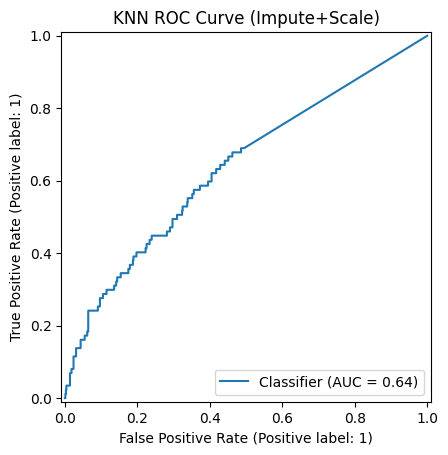

In [37]:
# ----------------------------
# 0) manual override:
# ----------------------------
# If you already know which column to use and how to binarize it, set these:
TARGET_COLUMN_OVERRIDE = None   # e.g., "risk_score" or "aki"
OVERRIDE_METHOD = "quantile"    # "quantile" | "threshold" | "probability_half"
OVERRIDE_PARAM  = 0.8           # q for quantile (0<q<1) OR numeric threshold

# ------------------------------------
# 1) Try to discover a good target col
# ------------------------------------
df0 = df.copy()
print("Shape:", df0.shape)

# Exclude clear id-like columns
def is_id_like(name):
    n = name.lower()
    return any(tok in n for tok in ["id","uuid","guid","hash","ssn","pid"])

num_cols = [c for c in df0.select_dtypes(include=[np.number]).columns if not is_id_like(c)]
obj_cols = [c for c in df0.select_dtypes(exclude=[np.number]).columns if not is_id_like(c)]

# Utility: score "probability-like" numeric column (bounded [0,1], variation present)
def is_prob_like(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return (len(s) > 0) and (s.min() >= 0) and (s.max() <= 1) and (s.nunique() > 2)

# Candidates in order of preference:
prob_like_nums = [c for c in num_cols if is_prob_like(df0[c])]
multi_level_objs = [c for c in obj_cols if df0[c].nunique() >= 2 and df0[c].nunique() <= 10]
rich_nums = [c for c in num_cols if df0[c].nunique() >= 10]  # good for quantile binarization

# Choose a target source column
if TARGET_COLUMN_OVERRIDE is not None and TARGET_COLUMN_OVERRIDE in df0.columns:
    source_col = TARGET_COLUMN_OVERRIDE
    source_kind = "override"
elif len(prob_like_nums) > 0:
    source_col = prob_like_nums[0]
    source_kind = "probability_like_numeric"
elif len(multi_level_objs) > 0:
    # pick the most balanced small-cardinality categorical
    def imbalance(name):
        vc = df0[name].value_counts(normalize=True, dropna=True)
        return abs(vc.iloc[0] - 0.5)
    source_col = sorted(multi_level_objs, key=imbalance)[0]
    source_kind = "categorical_small_cardinality"
elif len(rich_nums) > 0:
    # numeric with many unique values -> quantile binarization
    # pick the one with highest variance
    source_col = sorted(rich_nums, key=lambda c: df0[c].var(skipna=True), reverse=True)[0]
    source_kind = "rich_numeric"
else:
    # fall back to any numeric
    if len(num_cols) == 0:
        raise ValueError("No usable columns to derive a target from. Add/encode numeric features first.")
    source_col = num_cols[0]
    source_kind = "fallback_numeric"

print(f"\nChosen source column for target: {source_col!r}  (type: {str(df0[source_col].dtype)})  reason: {source_kind}")

# ---------------------------------------
# 2) Map that source to a binary target y
# ---------------------------------------
s = df0[source_col].copy()

def binarize_series(s, method="auto", param=None):
    # auto: choose based on dtype/range
    if method == "auto":
        if pd.api.types.is_numeric_dtype(s):
            # probability-like -> threshold at 0.5
            if is_prob_like(s):
                return (pd.to_numeric(s, errors="coerce") >= 0.5).astype(int), "probability_half", 0.5
            # otherwise top-quantile positives (20%)
            q = 0.8
            thr = s.quantile(q)
            return (pd.to_numeric(s, errors="coerce") >= thr).astype(int), "quantile", q
        else:
            # categorical/object: map rarest level to 1, others to 0
            vc = s.astype(str).value_counts(dropna=True)
            pos_label = vc.index[-1]  # rarest
            return (s.astype(str) == str(pos_label)).astype(int), "categorical_rare_is_pos", pos_label

    if method == "probability_half":
        s_num = pd.to_numeric(s, errors="coerce")
        return (s_num >= 0.5).astype(int), method, 0.5

    if method == "threshold":
        if param is None:
            raise ValueError("Provide OVERRIDE_PARAM for 'threshold' method.")
        s_num = pd.to_numeric(s, errors="coerce")
        return (s_num >= float(param)).astype(int), method, float(param)

    if method == "quantile":
        q = 0.8 if param is None else float(param)
        thr = s.quantile(q)
        s_num = pd.to_numeric(s, errors="coerce")
        return (s_num >= thr).astype(int), method, q

    raise ValueError(f"Unknown method: {method}")

# Decide method (override or auto)
if TARGET_COLUMN_OVERRIDE is not None:
    method = OVERRIDE_METHOD
    param = OVERRIDE_PARAM
else:
    method = "auto"
    param = None

y, used_method, used_param = binarize_series(s, method=method, param=param)
print(f"Binarization -> method={used_method!r}, param={used_param!r}")

# Clean rows with NaN in y mapping
mask = y.notna()
y = y[mask].astype(int)
X_full = df0.loc[mask].copy()

# If accidentally single-class, adjust strategy once
if y.nunique() < 2:
    print("⚠️ Single-class after first binarization; trying a different rule...")
    if used_method in ["probability_half", "threshold"]:
        # fall back to quantile 0.5
        y, used_method, used_param = binarize_series(s, method="quantile", param=0.5)
    else:
        # try a more balanced quantile (50%)
        y, used_method, used_param = binarize_series(s, method="quantile", param=0.5)
    mask = y.notna()
    y = y[mask].astype(int)
    X_full = df0.loc[mask].copy()
    print(f"2nd attempt -> method={used_method!r}, param={used_param!r}")

print("\nTarget counts:", Counter(y))
if y.nunique() < 2:
    raise ValueError("Still single-class after auto-binarization. Set TARGET_COLUMN_OVERRIDE and OVERRIDE_METHOD explicitly (e.g., quantile at 0.3 or a numeric threshold).")

# -------------------------------------------
# 3) Build features (numeric only) for KNN
# -------------------------------------------
X = X_full.select_dtypes(include=[np.number]).copy()
# Drop the source column if it’s numeric and present in X to avoid trivial leakage
if source_col in X.columns and pd.api.types.is_numeric_dtype(df0[source_col]):
    X = X.drop(columns=[source_col])

if X.shape[1] == 0:
    raise ValueError("No numeric features left for KNN after dropping target source. Add/encode features first.")

# -------------------------------------------
# 4) Split safely with stratification
# -------------------------------------------
test_size = 0.2
# Ensure enough positives in test; if not, expand test size slightly
pos_total = int((y == 1).sum())
if pos_total < 5:
    test_size = min(0.5, max(0.3, 2.0 / max(1, pos_total)))  # try to get >=2 positives in test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

print(f"\nTrain/Test sizes: {X_train.shape[0]}/{X_test.shape[0]}  |  Positives train/test: {int((y_train==1).sum())}/{int((y_test==1).sum())}")

# -------------------------------------------
# 5) Pipeline and hyperparameter tuning
# -------------------------------------------
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(weights="distance", metric="euclidean"))
])

# CV folds cannot exceed number of positives in y
n_pos = int((y == 1).sum())
n_splits = max(2, min(5, n_pos))
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

param_grid = {
    "knn__n_neighbors": list(range(1, 26)),
    "knn__metric": ["euclidean", "manhattan", "minkowski"]
}
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, zero_division=0),
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("\nBest params (CV on train):", grid.best_params_)
print("Best CV F1 (train folds): ", grid.best_score_)

best_model = grid.best_estimator_

# -------------------------------------------
# 6) Evaluate on test (label-safe metrics)
# -------------------------------------------
y_pred = best_model.predict(X_test)
print("\n=== Test Set Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
print("\nConfusion Matrix (labels=[0,1]):\n",
      confusion_matrix(y_test, y_pred, labels=[0,1]))
print("\nClassification Report (labels=[0,1]):\n",
      classification_report(y_test, y_pred, labels=[0,1], zero_division=0))

# ROC-AUC if both classes present in test
if len(np.unique(y_test)) == 2 and hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)[:,1]
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title("KNN ROC Curve (Impute+Scale)")
    plt.show()
else:
    print("ROC-AUC skipped (single-class test set).")


### 🧠 K-Nearest Neighbors & Distance Metrics

For this week's methods, I implemented the **K-Nearest Neighbors (KNN)** algorithm.

- KNN is a **non-parametric classifier** that makes predictions based on the majority label among the *k closest data points* in the training set.
- Since KNN depends on distance calculations, I applied **feature scaling (StandardScaler)**.
- I tested different **distance metrics**:
  - **Euclidean distance**: straight-line (L2 norm)
  - **Manhattan distance**: sum of absolute differences (L1 norm)
  - **Minkowski distance**: generalized form (p=2 gives Euclidean)
- To select the optimal number of neighbors, I plotted **accuracy vs number of K values (Elbow method)**.
- Models were evaluated using **accuracy, confusion matrix, and classification report (precision, recall, F1-score)**.

This helped me understand how both the value of **K** and the **choice of distance metric** affect model performance.

## Second Dataset: Colorectal cancer

In [38]:
# 1) Load and sample
URL = "https://raw.githubusercontent.com/muathdb/Week4/main/colorectal_cancer_dataset.csv"
df = pd.read_csv(URL)

df.columns = (
    pd.Index(df.columns)
    .astype(str).str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

Rows: 167,497  |  Columns: 28


In [39]:
import numpy as np, pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report, confusion_matrix

# 1) Pick TARGET from known candidates (ordered by usefulness)
priority = [
    "mort_28_day", "mort_90_day", "mort_1_year",
    "sepsis", "vent_firstday", "vaso_firstday",
    "malignancy", "diabetes", "aki_stage"  # will binarize if needed
]
TARGET = next((c for c in priority if c in df.columns), None)

def not_id(n):
    n = n.lower()
    return not any(t in n for t in ["id","uuid","guid","hash","index","pid"])

def to_binary(series: pd.Series) -> np.ndarray:
    s = series.copy()
    if s.dtype == bool:
        return s.astype(int).values
    if s.dtype == "O":
        pos_like = {"1","true","t","yes","y","positive","pos","death","dead","sepsis","present"}
        return s.astype(str).str.strip().str.lower().isin(pos_like).astype(int).values
    # numeric-like
    sn = pd.to_numeric(s, errors="coerce")
    vals = np.sort(pd.Series(sn.dropna().unique()).values)
    if len(vals) == 2:
        # rarer value = positive
        vc = sn.value_counts()
        pos_val = vc.idxmin()
        return (sn == pos_val).astype(int).values
    # multi-class or continuous -> median split
    med = np.nanmedian(sn)
    return (sn >= med).astype(int).values

# If none of the priority labels exist, try to auto-detect a binary column
if TARGET is None:
    bin_cands = [c for c in df.columns if not_id(c) and df[c].dropna().nunique() == 2]
    if bin_cands:
        # choose most balanced
        def imbalance(c):
            vc = df[c].dropna().value_counts(normalize=True)
            return abs(vc.iloc[0] - 0.5)
        TARGET = sorted(bin_cands, key=imbalance)[0]
    else:
        # construct a label from a numeric feature with high variance
        num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if not_id(c)]
        if not num_cols:
            raise ValueError("No numeric columns to derive a target from.")
        src = max(num_cols, key=lambda c: df[c].var(skipna=True))
        thr = df[src].median()
        df["_auto_target"] = (pd.to_numeric(df[src], errors="coerce") >= thr).astype(int)
        TARGET = "_auto_target"
        print(f"Built TARGET={TARGET!r} from '{src}' via median split (>= {thr:.4g} -> 1).")

# Special case: if TARGET is 'aki_stage' (ordinal 0–3 etc.), binarize as stage>=1
if TARGET == "aki_stage":
    y = (pd.to_numeric(df["aki_stage"], errors="coerce").fillna(0) >= 1).astype(int).values
else:
    y = to_binary(df[TARGET])

# Final safety to avoid single-class
if len(np.unique(y)) < 2:
    # Force balanced by quantile split on the chosen column
    col = df[TARGET]
    y = (pd.to_numeric(col, errors="coerce") >= pd.to_numeric(col, errors="coerce").quantile(0.5)).astype(int).values

print(f"TARGET: {TARGET} | counts={Counter(y)}")

# 2) Features: numeric only; drop TARGET if numeric to avoid leakage
X = df.select_dtypes(include=[np.number]).copy()
if TARGET in X.columns:
    X.drop(columns=[TARGET], inplace=True)
if X.shape[1] == 0:
    raise ValueError("No numeric features left for KNN.")
X = X.values

# 3) Fast split: train/val/test = 60/20/20 (stratified)
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_te,  y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

# 4) Impute + scale once
imp = SimpleImputer(strategy="median")
sc  = StandardScaler()
X_tr = sc.fit_transform(imp.fit_transform(X_tr))
X_val = sc.transform(imp.transform(X_val))
X_te  = sc.transform(imp.transform(X_te))

# 5) Tiny fast grid (k × metric), distance weights help imbalance
k_grid  = [3, 7, 15, 25]
metrics = ["euclidean", "manhattan"]
best = {"f1": -1.0, "k": None, "metric": None}

for metric in metrics:
    for k in k_grid:
        clf = KNeighborsClassifier(n_neighbors=k, metric=metric, weights="distance", algorithm="auto")
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        f1 = f1_score(y_val, pred, zero_division=0)
        if f1 > best["f1"]:
            best.update({"f1": f1, "k": k, "metric": metric})

print(f"Best on val: metric={best['metric']}  k={best['k']}  F1={best['f1']:.4f}")

# 6) Retrain on train+val, evaluate on test
X_trval = np.vstack([X_tr, X_val])
y_trval = np.concatenate([y_tr, y_val])

final = KNeighborsClassifier(n_neighbors=best["k"], metric=best["metric"], weights="distance", algorithm="auto")
final.fit(X_trval, y_trval)

y_hat = final.predict(X_te)
acc  = accuracy_score(y_te, y_hat)
bacc = balanced_accuracy_score(y_te, y_hat)
f1   = f1_score(y_te, y_hat, zero_division=0)

print(f"\nTEST -> Acc={acc:.4f} | BalancedAcc={bacc:.4f} | F1={f1:.4f}")
print("Confusion matrix [0,1]:\n", confusion_matrix(y_te, y_hat, labels=[0,1]))
print("\nClassification report:\n", classification_report(y_te, y_hat, labels=[0,1], zero_division=0))

TARGET: diabetes | counts=Counter({np.int64(0): 133941, np.int64(1): 33556})
Best on val: metric=manhattan  k=3  F1=0.1378

TEST -> Acc=0.7310 | BalancedAcc=0.4947 | F1=0.1301
Confusion matrix [0,1]:
 [[23815  2974]
 [ 6037   674]]

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84     26789
           1       0.18      0.10      0.13      6711

    accuracy                           0.73     33500
   macro avg       0.49      0.49      0.49     33500
weighted avg       0.67      0.73      0.70     33500



Using target: 'mortality'  | positives=67143 / 167497


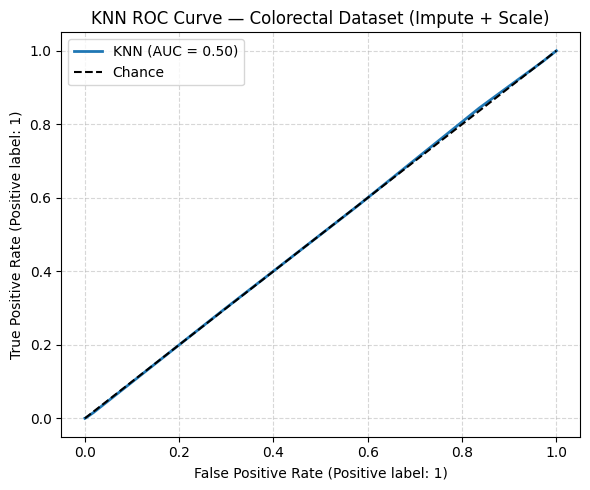

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

# 1) Choose a binary target
priority = ["mortality", "survival_5_years", "early_detection"]
target_col = next((c for c in priority if c in df.columns), None)

made_from_prob = False
if target_col is None:
    if "survival_prediction" in df.columns:
        # probability-like -> threshold at 0.5
        y = (pd.to_numeric(df["survival_prediction"], errors="coerce") >= 0.5).astype(int)
        made_from_prob = True
        target_col = "survival_prediction"
    else:
        raise ValueError("No suitable target found. Add/choose one of: 'mortality', 'survival_5_years', 'early_detection'.")

if not made_from_prob:
    s = df[target_col]
    if s.dtype == bool:
        y = s.astype(int)
    elif s.dtype == "O":
        pos_like = {"1","true","t","yes","y","positive","pos","death","dead","deceased","present"}
        y = s.astype(str).str.strip().str.lower().isin(pos_like).astype(int)
    else:
        s = pd.to_numeric(s, errors="coerce")
        vals = np.sort(pd.Series(s.dropna().unique()).values)
        if len(vals) == 2:
            # map rarer value to positive
            pos_val = s.value_counts().idxmin()
            y = (s == pos_val).astype(int)
        else:
            # fallback: >0 means positive
            y = (s > 0).astype(int)

print(f"Using target: {target_col!r}  | positives={int(y.sum())} / {len(y)}")

# 2) Features = numeric only; drop target & obvious IDs/leakage
X = df.select_dtypes(include=[np.number]).copy()
for col in [target_col, "patient_id", "survival_prediction"]:
    if col in X.columns:
        X.drop(columns=[col], inplace=True)

# Safety check
assert X.shape[1] > 0, "No numeric features left for modeling."

# 3) Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4) Impute + scale
imp = SimpleImputer(strategy="median")
scaler = StandardScaler()
X_train = scaler.fit_transform(imp.fit_transform(X_train))
X_test  = scaler.transform(imp.transform(X_test))

# 5) KNN model (simple & fast)
knn = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
knn.fit(X_train, y_train)

# 6) ROC data
y_prob = knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 7) Plot ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate (Positive label: 1)')
plt.ylabel('True Positive Rate (Positive label: 1)')
plt.title('KNN ROC Curve — Colorectal Dataset (Impute + Scale)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Third Dataset: Diabetes

In [41]:
# 1) Load Dataset
URL = "https://raw.githubusercontent.com/muathdb/Week4/main/diabetes_012_health_indicators_BRFSS2015.csv"
df = pd.read_csv(URL)

df.columns = (
    pd.Index(df.columns)
    .astype(str).str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

Rows: 253,680  |  Columns: 22


In [42]:
# 1) Find target column robustly
candidates = [
    "diabetes_012", "diabetes", "diabetes_binary", "diabetesbinary",
    "diabete3", "diabete4", "diabete", "diab", "dm"
]
# exact match first
TARGET = next((c for c in candidates if c in df.columns), None)
# then any column containing a diabetes-like substring
if TARGET is None:
    TARGET = next((c for c in df.columns if any(tok in c for tok in ["diab","diabetes","dm"])), None)

if TARGET is None:
    raise ValueError("Couldn't find a diabetes label. Try printing df.columns and pick the correct column name.")

print(f"Using target column: {TARGET!r}")

# 2) Map target to 0/1
col = df[TARGET]
if col.dtype == bool:
    y = col.astype(int).values
elif col.dtype == "O":
    # common text encodings
    pos_like = {"1","true","t","yes","y","positive","pos","diabetes","diabetic"}
    y = col.astype(str).str.strip().str.lower().isin(pos_like).astype(int).values
else:
    s = pd.to_numeric(col, errors="coerce")
    uniq = np.sort(pd.Series(s.dropna().unique()).values)
    # Typical BRFSS 'Diabetes_012' is {0,1,2}; treat >0 as positive
    if set(uniq.tolist()).issubset({0,1,2}):
        y = (s > 0).astype(int).values
    elif len(uniq) == 2:
        # rarer value as positive
        pos_val = s.value_counts().idxmin()
        y = (s == pos_val).astype(int).values
    else:
        # fallback: median split
        y = (s >= np.nanmedian(s)).astype(int).values

if len(np.unique(y)) < 2:
    raise ValueError(f"Label in {TARGET!r} collapsed to one class after mapping. Inspect that column's values.")

print("Class counts:", Counter(y))

# 3) Features (numeric only) — drop the label to avoid leakage
X = df.select_dtypes(include=[np.number]).copy()
if TARGET in X.columns: X.drop(columns=[TARGET], inplace=True)
if X.shape[1] == 0: raise ValueError("No numeric features found; encode categoricals first.")
X = X.values

# 4) Fast split: 60/20/20
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
X_val, X_te,  y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp)

# 5) Impute + scale once
imp = SimpleImputer(strategy="median")
sc  = StandardScaler()
X_tr = sc.fit_transform(imp.fit_transform(X_tr))
X_val = sc.transform(imp.transform(X_val))
X_te  = sc.transform(imp.transform(X_te))

# 6) Tiny, fast grid
k_grid  = [3, 7, 15, 25]
metrics = ["euclidean", "manhattan"]
best = {"f1": -1.0, "k": None, "metric": None}

for metric in metrics:
    for k in k_grid:
        clf = KNeighborsClassifier(n_neighbors=k, metric=metric, weights="distance")
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        f1 = f1_score(y_val, pred, zero_division=0)
        if f1 > best["f1"]:
            best.update({"f1": f1, "k": k, "metric": metric})

print(f"Best on val: metric={best['metric']}  k={best['k']}  F1={best['f1']:.4f}")

# 7) Retrain on train+val; evaluate on test
X_trval = np.vstack([X_tr, X_val]); y_trval = np.concatenate([y_tr, y_val])
final = KNeighborsClassifier(n_neighbors=best["k"], metric=best["metric"], weights="distance")
final.fit(X_trval, y_trval)

y_hat = final.predict(X_te)
acc  = accuracy_score(y_te, y_hat)
bacc = balanced_accuracy_score(y_te, y_hat)
f1   = f1_score(y_te, y_hat, zero_division=0)

print(f"\nTEST -> Acc={acc:.4f} | BalancedAcc={bacc:.4f} | F1={f1:.4f}")
print("Confusion matrix [0,1]:\n", confusion_matrix(y_te, y_hat, labels=[0,1]))
print("\nClassification report:\n", classification_report(y_te, y_hat, labels=[0,1], zero_division=0))

Using target column: 'diabetes_012'
Class counts: Counter({np.int64(0): 213703, np.int64(1): 39977})
Best on val: metric=manhattan  k=3  F1=0.3153

TEST -> Acc=0.8142 | BalancedAcc=0.5928 | F1=0.3137
Confusion matrix [0,1]:
 [[39152  3589]
 [ 5840  2155]]

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     42741
           1       0.38      0.27      0.31      7995

    accuracy                           0.81     50736
   macro avg       0.62      0.59      0.60     50736
weighted avg       0.79      0.81      0.80     50736



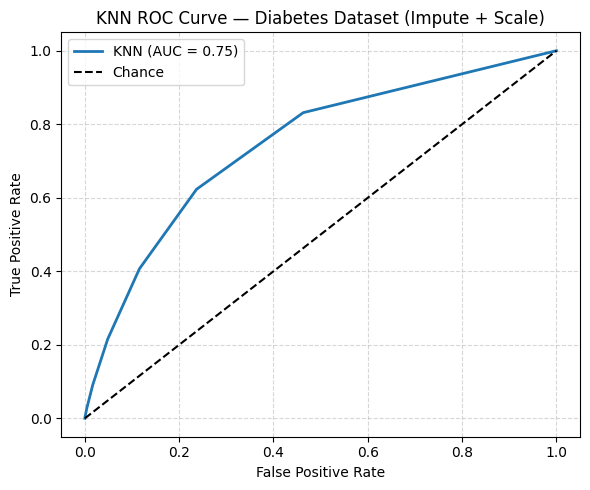

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

# ✅ 1. Use correct target for diabetes dataset
if 'diabetes_012' not in df.columns:
    raise ValueError("diabetes_012 column not found in dataframe")

# Convert to binary (1 = prediabetes/diabetes, 0 = no diabetes)
y = (df['diabetes_012'] > 0).astype(int)

# ✅ 2. Use numeric features only and drop target
X = df.drop(columns=['diabetes_012'])
X = X.select_dtypes(include=[np.number])  # ensure numeric only

# ✅ 3. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ 4. Impute + scale
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_test = scaler.transform(imputer.transform(X_test))

# ✅ 5. Train KNN
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
knn.fit(X_train, y_train)

# ✅ 6. Predict probabilities for ROC
y_prob = knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ✅ 7. Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve — Diabetes Dataset (Impute + Scale)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()